### Load Damagescanner package

In [1]:
import os,sys
import rasterio
import pyproj
import shapely
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
import osmnx as ox
import networkx as nx

#sys.path.append("../src/damagescanner")

from damagescanner.core import VectorScanner 
from damagescanner.vector import roads,landuse,buildings

data_path = '..'

C:\Users\eks510\.conda\envs\ds_env\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
C:\Users\eks510\AppData\Local\Temp\ipykernel_18472\2433900443.py:8: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthe

### Read input data

In [2]:
inun_map = os.path.join(data_path,'data','inundation','inundation_map.tif')
landuse_map = os.path.join(data_path,'data','landuse','landuse.shp')
kampen = os.path.join(data_path,'data','landuse','kampen.osm.pbf') 

C:\Users\eks510\.conda\envs\ds_env\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<AxesSubplot: >

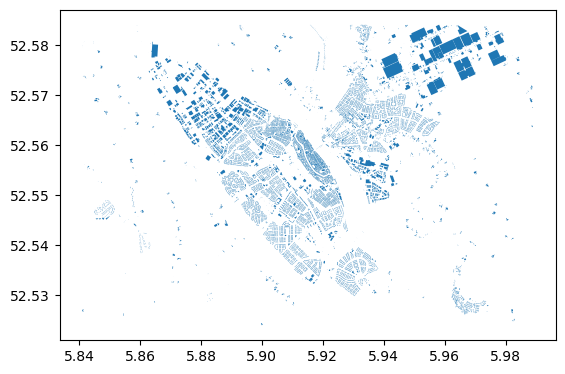

In [3]:
buildings(kampen).plot()

In [4]:
place_name = 'Kampen, The Netherlands'
cf = '["highway"~"trunk|motorway|primary|secondary|tertiary"]'
G = ox.graph_from_place(place_name, network_type="drive", custom_filter=cf)

roads = gpd.GeoDataFrame(nx.to_pandas_edgelist(G))
roads = roads.set_crs(epsg=4326)
roads.highway = roads.highway.astype('str')

### Create dummy maximum damage dictionary and curves DataFrame

In [5]:
maxdam = {"grass":5,
        "forest":10,
        "orchard":50,
        "residential":200,
        "industrial":300,
        "retail":300,
        "farmland":10,
        "cemetery":15,
        "construction":10,
        "meadow":5,
        "farmyard":5,
        "scrub":5,
        "allotments":10,
        "reservoir":5,
        "static_caravan":100,
        "commercial":300}

curves = np.array(
            [[0,0],
            [50,0.2],
            [100,0.4],
            [150,0.6],
            [200,0.8],
            [250,1]])  
    
curves = np.concatenate((curves,
                            np.transpose(np.array([curves[:,1]]*(len(maxdam)-1)))),
                           axis=1)

curves = pd.DataFrame(curves)
curves.columns = ['depth']+list(maxdam.keys())
curves.set_index('depth',inplace=True)    

In [6]:
road_maxdam =  {"trunk":500,
        "trunk_link":500,
        "secondary":300,
        "primary":400,
        "tertiary":200,
        "primary_link":400,
        "tertiary_link":200,
        "secondary_link":300}

road_curves = np.array(
            [[0,0],
            [50,0.2],
            [100,0.4],
            [150,0.6],
            [200,0.8],
            [250,1]])  
    
road_curves = np.concatenate((road_curves,
                            np.transpose(np.array([road_curves[:,1]]*(len(road_maxdam)-1)))),
                           axis=1)

road_curves = pd.DataFrame(road_curves)
road_curves.columns = ['depth']+list(road_maxdam.keys())
road_curves.set_index('depth',inplace=True)    

### Run the VectorScanner

For a road system

In [7]:
%%time
road_damage = VectorScanner(roads,
                            inun_map,
                            road_curves,
                            road_maxdam,
                            cell_size = 5,
                            exp_crs = 4326,
                            haz_crs = 28992,
                            object_col='highway',
                            hazard_col='inun_val',
                            centimeters=False,
                            save=False)

PROGRESS: Exposure and hazard data loaded


damage calculation: 100%|███████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 293.78it/s]


CPU times: total: 43.2 s
Wall time: 43.2 s


For a vectorized landuse map

In [ ]:
%%time
lu_damage = VectorScanner(landuse_map,
                            inun_map,
                            curves,
                            maxdam,
                            cell_size = 5,
                            exp_crs = 28992,
                            haz_crs = 28992,
                            object_col='landuse',
                            hazard_col='inun_val',
                            centimeters=False,
                            save=False)

PROGRESS: Exposure and hazard data loaded


damage calculation:   2%|█▎                                                         | 100/4345 [00:21<23:19,  3.03it/s]